In [1]:
!nvidia-smi

Fri Jun 17 14:28:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 23%   26C    P8    16W / 250W |  10916MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 23%   

In [2]:
from jarvis.utils.general import gpus

gpus.autoselect()

[ 2022-06-17 14:28:54 ] WARNING 1 GPU device(s) requested but only 0 available 


In [3]:
import numpy as np
from jarvis.train import datasets
from jarvis.utils.display import imshow
from tensorflow.keras import Input
from jarvis.train.client import Client

from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
def show_mri(mri):
    for i in range(mri.shape[0]):
        clear_output(wait=True)
        plt.axis(False)
        plt.imshow(mri[i, :, :, 0], cmap='gray')
        plt.show()

In [5]:
# --- prepare generators
client = Client('/data/raw/miccai_rsna/data/ymls/client-3d.yml')
gen_train, gen_valid = client.create_generators()

In [6]:
# --- Show a sample training set
xs, ys = next(gen_train)
# imshow(xs['t2w'][0][24], radius=1)
print(ys['lbl'][0])

[[[[1]]]]


In [7]:
flair = xs['fla']
flair.shape

(4, 48, 96, 96, 1)

In [8]:
flair1 = flair[0]

In [9]:
flair1.shape

(48, 96, 96, 1)

In [10]:
np.min(flair1)

-0.9095502322345922

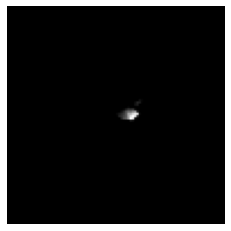

In [11]:
show_mri(flair[1])

In [12]:
ys

{'lbl': array([[[[[1]]]],
 
 
 
        [[[[0]]]],
 
 
 
        [[[[0]]]],
 
 
 
        [[[[0]]]]], dtype=uint8)}

In [13]:
ys['lbl'][:, 0, 0, 0]

array([[1],
       [0],
       [0],
       [0]], dtype=uint8)

In [14]:
xs.keys()

dict_keys(['t2w', 't1w', 't1wce', 'fla', 'lbl'])

In [15]:
# --- Print keys 
for key, arr in xs.items():
    print('xs key: {} | shape = {}'.format(key.ljust(8), arr.shape))

xs key: t2w      | shape = (4, 48, 96, 96, 1)
xs key: t1w      | shape = (4, 48, 96, 96, 1)
xs key: t1wce    | shape = (4, 48, 96, 96, 1)
xs key: fla      | shape = (4, 48, 96, 96, 1)
xs key: lbl      | shape = (4, 1, 1, 1, 1)


In [16]:
# --- Create model inputs
inputs = client.get_inputs(Input)

In [17]:
inputs

{'t2w': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't2w')>,
 't1w': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't1w')>,
 't1wce': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't1wce')>,
 'fla': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 'fla')>,
 'lbl': <KerasTensor: shape=(None, 1, 1, 1, 1) dtype=uint8 (created by layer 'lbl')>}

In [18]:
from ResNet10.ResNet10_3D import build_resnet
base_model = build_resnet()

In [19]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['acc'])

In [20]:
from tensorflow.keras.losses import BinaryCrossentropy

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
bce = BinaryCrossentropy()
# @tf.function
def train_step(x, y):
#     print(y.shape)
    loss = base_model.train_on_batch(x, y)
#     with tf.GradientTape() as tape:
# #         print('beginning training...')
#         y_hat = base_model(x, training=True)
# #         print(y_hat.shape)
# #         print('done training...')
#         loss = bce(y, y_hat)
#     grads = tape.gradient(loss, base_model.trainable_variables)
#     opt.apply_gradients(zip(grads, base_model.trainable_variables))
    return loss

In [22]:
annoying_case = None
annoying_case_unproc = None

In [23]:
def train(train_dataset, n_epochs=1, max_steps_per_epoch=None):
    global annoying_case, annoying_case_unproc
    for epoch in range(n_epochs):
        for i, batch in enumerate(train_dataset):
            xs, ys = batch
            inp = np.empty((4, 48, 96, 96, 4))
            inp[:, :, :, :, 0] = xs['t2w'][:, :, :, 0]
            inp[:, :, :, :, 1] = xs['t1w'][:, :, :, 0]
            inp[:, :, :, :, 2] = xs['t1wce'][:, :, :, 0]
            inp[:, :, :, :, 3] = xs['fla'][:, :, :, 0]
#             print(xs['fla'].shape)
#             fla = xs['fla']
            x_prep = inp # (inp-np.min(inp))/(np.max(inp)-np.min(inp))
            if max_steps_per_epoch is not None:
                if i == max_steps_per_epoch:
                    break
#             adversarial = (epoch >= 1)
            if(np.isnan(x_prep).any()):
                continue
            l1 = train_step(x_prep, ys['lbl'].reshape(4, 1))#[:, 0, 0, 0])
#             del batch
            clear_output(wait=True)
            if np.isnan(np.max(x_prep)) or np.isnan(np.min(x_prep)):
                annoying_case = x_prep
                annoying_case_unproc = fla
#             show_mri(x_prep[0])
            print("Epoch {}/{}".format(epoch + 1, n_epochs))
            print(f'Step {i+1}')
#             print(f'MRI Shape: {x_prep.shape}')
#             print(f'Max Flair: {np.max(x_prep)}')
#             print(f'Min Flair: {np.min(x_prep)}')
            print(f'Loss: {l1}')
            

In [24]:
print(tf.test.gpu_device_name())

In [25]:
# --- prepare generators
client = Client('/data/raw/miccai_rsna/data/ymls/client-3d.yml')
gen_train, gen_valid = client.create_generators()
train(gen_train, max_steps_per_epoch=100, n_epochs=1)

KeyboardInterrupt: 

In [27]:
NUM_VAL_SCANS = 100

In [28]:
preds = []
labels = []
for i, batch in enumerate(gen_valid):
    xs, ys = batch
    pred = base_model.predict(xs['fla'])
    y = ys['lbl']
    labels.append(y.reshape(4, 1))
    preds.append(pred)
    if i == NUM_VAL_SCANS:
        break

In [29]:
preds = np.array(preds).reshape(-1,)
labels = np.array(labels).reshape(-1,)

In [30]:
preds

array([0.42531955, 0.5723657 , 0.43261427, 0.43311775, 0.70956856,
       0.44074088, 0.4776696 , 0.43135336, 0.45288268, 0.4192042 ,
       0.41218695, 0.36345667, 0.442863  , 0.5072268 , 0.4459786 ,
       0.4035986 , 0.4688085 , 0.4258069 , 0.37644556, 0.20193318,
       0.596744  , 0.46565664, 0.44616163, 0.41080862, 0.5828575 ,
       0.42218193, 0.4411989 , 0.39959672, 0.40833747, 0.4631559 ,
       0.42026815, 0.4183041 , 0.47352093, 0.38134593, 0.51032627,
       0.418901  , 0.4304616 , 0.42843008, 0.45646054, 0.43224606,
       0.6394574 , 0.35966563, 0.6036318 , 0.44432354, 0.28636777,
       0.45510805, 0.46283802, 0.4736457 , 0.38456583, 0.4151377 ,
       0.42144024, 0.583315  , 0.32162297, 0.55345637, 0.41629454,
       0.6479506 , 0.4247523 , 0.59272057, 0.4339219 , 0.42032212,
       0.48431605, 0.4261551 , 0.49194357, 0.45418754, 0.41211915,
       0.4131581 , 0.5402255 , 0.42071694, 0.43794477, 0.58010024,
       0.42362925, 0.43523523, 0.43698606, 0.4173553 , 0.45575

In [31]:
preds[preds > 0.5] = 1
preds[preds <= 0.5] = 0

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
acc = accuracy_score(preds, labels)
print(f'Validated on {NUM_VAL_SCANS} scans...')
print(f'Accuracy: {acc}')

Validated on 100 scans...
Accuracy: 0.5544554455445545
